In [1]:
# !pip install keras
# !pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('merged_data.csv', sep='\t', encoding='utf-8')

try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    pass

display(
    df.head(15),
    df.tail(15),
    df.describe()
)

,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total,inc_grippe,inc_diarrhee,inc_varicelle,has_vacation,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
0,201001,81.0,232.0,0.0,129.0,1397.0,1839.0,10207,42889,3735,0.0,-0.0,-10.0,-4.43,2.6,3.2
1,201002,84.0,163.0,1.0,144.0,1383.0,1775.0,9134,61576,3120,0.0,8.0,-5.0,0.71,1.5,2.5
2,201003,74.0,107.0,0.0,123.0,1192.0,1496.0,4816,60448,1420,0.0,7.0,-1.0,2.29,0.0,1.9
3,201004,78.0,105.0,0.0,130.0,1316.0,1629.0,4348,61601,1284,0.0,5.0,-5.0,0.43,0.2,0.7
4,201005,84.0,111.0,0.0,117.0,1341.0,1653.0,2888,47258,6835,0.0,9.0,-2.0,4.29,0.2,10.5
5,201006,103.0,129.0,1.0,120.0,1350.0,1703.0,1695,44471,3463,0.0,3.0,-7.0,-2.57,0.7,1.8
6,201007,84.0,106.0,0.0,145.0,1307.0,1642.0,2646,39867,7090,1.0,8.0,-6.0,1.00,0.2,3.1
7,201008,72.0,1086.0,0.0,133.0,1197.0,2488.0,3000,29301,5632,1.0,12.0,4.0,8.14,0.0,9.4
8,201009,74.0,161.0,5.0,156.0,1095.0,1491.0,1023,28556,5897,1.0,10.0,-4.0,2.86,0.0,1.7
9,201010,58.0,124.0,11.0,152.0,1238.0,1583.0,260,32471,4801,0.0,7.0,-3.0,1.29,0.0,0.0


,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total,inc_grippe,inc_diarrhee,inc_varicelle,has_vacation,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
401,201738,105.0,91.0,1.0,114.0,1512.0,1823.0,1065,8373,56,0.0,23.0,9.0,14.00,0.0,1.4
402,201739,96.0,73.0,2.0,106.0,1512.0,1789.0,7661,10671,227,0.0,25.0,12.0,16.57,0.0,3.5
403,201740,105.0,69.0,2.0,93.0,1404.0,1673.0,2001,13710,547,0.0,18.0,7.0,13.29,0.0,4.0
404,201741,98.0,68.0,1.0,101.0,1602.0,1870.0,1857,11327,0,0.0,24.0,10.0,15.57,0.0,0.7
405,201742,98.0,88.0,0.0,110.0,1565.0,1861.0,1963,12027,37,1.0,25.0,10.0,15.86,0.0,1.2
406,201743,92.0,79.0,1.0,88.0,1411.0,1671.0,945,7602,759,1.0,20.0,7.0,13.14,0.0,0.7
407,201744,84.0,58.0,2.0,148.0,1313.0,1605.0,200,5887,96,1.0,16.0,5.0,10.00,0.0,1.0
408,201745,107.0,72.0,2.0,107.0,1500.0,1788.0,3612,11987,160,0.0,13.0,3.0,8.00,0.0,5.1
409,201746,96.0,73.0,1.0,104.0,1540.0,1814.0,4854,15145,684,0.0,10.0,3.0,6.57,0.0,0.3
410,201747,120.0,50.0,2.0,106.0,1622.0,1900.0,3561,15815,894,0.0,15.0,2.0,8.43,0.0,1.9


,yearweek,ACCI,AUTR,INCN,INCU,SUAP,ope_total,inc_grippe,inc_diarrhee,inc_varicelle,has_vacation,temperature_max,temperature_min,temperature_average,total_snow_cm,precipitation_mm
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000
mean,201375.778846,89.132212,157.112981,4.807692,115.918269,1342.223558,1709.194712,8335.526442,15588.776442,2353.161058,0.420673,18.586538,4.286058,10.989471,0.079567,4.859615
std,229.975314,18.394979,159.785034,6.553692,25.737283,145.907977,210.164005,15612.126432,8908.085027,1915.938518,0.494262,7.670140,5.204484,6.026625,0.477989,4.943703
min,201001.000000,39.000000,35.000000,0.000000,57.000000,909.000000,1160.000000,0.000000,1721.000000,0.000000,0.000000,-1.000000,-10.000000,-5.710000,0.000000,0.000000
25%,201188.750000,78.000000,79.000000,1.000000,99.000000,1253.500000,1600.000000,458.500000,9124.500000,908.750000,0.000000,12.000000,0.000000,6.430000,0.000000,1.200000
50%,201351.500000,88.000000,108.000000,2.000000,111.000000,1357.000000,1692.000000,1924.500000,13797.000000,1927.500000,0.000000,19.000000,4.000000,11.000000,0.000000,3.200000
75%,201564.250000,101.000000,181.000000,7.000000,129.000000,1440.000000,1791.250000,6964.500000,19757.750000,3182.750000,1.000000,25.000000,9.000000,16.000000,0.000000,7.200000
max,201752.000000,145.000000,2107.000000,50.000000,296.000000,1972.000000,3763.000000,103790.000000,61601.000000,9572.000000,1.000000,37.000000,16.000000,24.290000,5.600000,30.300000


In [3]:
target_features = ['ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total']

def plot_expected_vs_predicted(model, train_test, force_predicted=None):
    comparison = pd.DataFrame(train_test['val_y']) # the expected values

    if force_predicted is None:
        comparison['predicted'] = model.predict(train_test['val_X'])
    else:
        comparison['predicted'] = force_predicted

    predicted_feature = comparison.columns[0]

    comparison = comparison.sort_values(by=[predicted_feature])

    comparison = comparison.reset_index(drop=True)

    model_name = type(model).__name__ # RandomForestRegressor, Sequential, etc.
    model_name = 'MLP' if model_name == 'Sequential' else model_name

    # comparison.plot()
    fig, ax = plt.subplots()
    a = comparison[predicted_feature]
    a.plot.line(ax=ax)
    plot = comparison.reset_index().plot.scatter(
        x='index', y='predicted', color="Orange", ax=ax, label='predicitons',
        title=f'predict {predicted_feature} with {model_name}\n(expected VS predicted)'
    )
    plt.show()

def display_mae_r2(model, train_test, force_predicted=None):

        if force_predicted is None:
            val_predictions = model.predict(train_test['val_X'])
        else:
            val_predictions = force_predicted

        mae = mean_absolute_error(train_test['val_y'], val_predictions)
        r2 = r2_score(train_test['val_y'], val_predictions)

        target_feature = train_test['val_y'].name # retrieve target feature from y

        model_name = type(model).__name__ # RandomForestRegressor, Sequential, etc.
        model_name = 'MLP' if model_name == 'Sequential' else model_name

        print(f'Predict {target_feature} with {model_name} :')
        print(f'MeanAbsoluteError:\t{mae}')
        print(f'R2 Score         :\t{r2}\n')

Predict ACCI with RandomForestRegressor :
MeanAbsoluteError:	14.13952380952381
R2 Score         :	0.18470823909340717



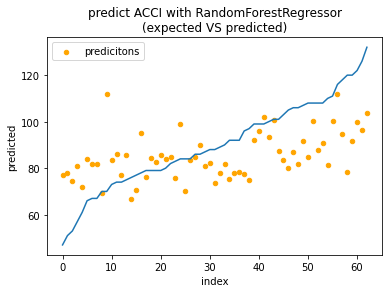

Predict AUTR with RandomForestRegressor :
MeanAbsoluteError:	71.36174603174604
R2 Score         :	-0.5174134068570189



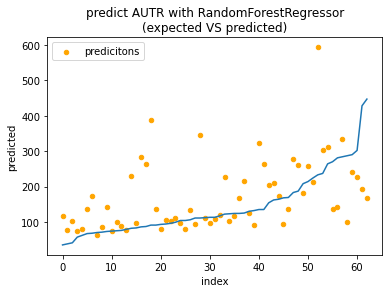

Predict INCN with RandomForestRegressor :
MeanAbsoluteError:	3.3460317460317452
R2 Score         :	0.3170953955395879



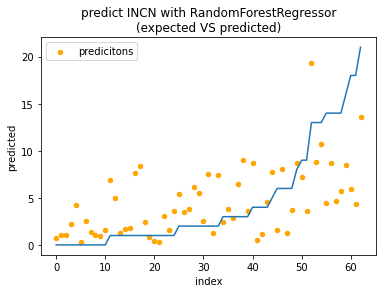

Predict INCU with RandomForestRegressor :
MeanAbsoluteError:	16.07
R2 Score         :	0.11015315982792606



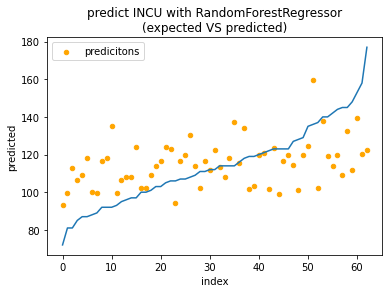

Predict SUAP with RandomForestRegressor :
MeanAbsoluteError:	88.94984126984127
R2 Score         :	0.4107497249906803



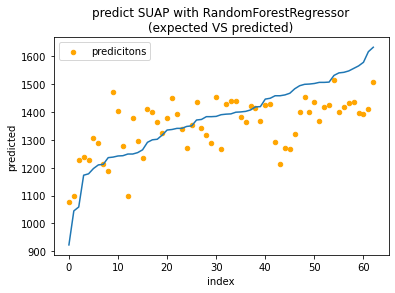

Predict ope_total with RandomForestRegressor :
MeanAbsoluteError:	113.09936507936506
R2 Score         :	0.23069023021759283



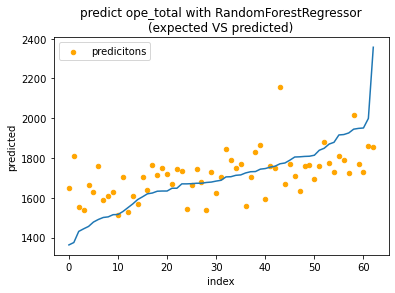

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def do_random_forest(target_feature='SUAP', train_test=None):

    model_random_forest = StandardScaler()

    # All columns except yearweek and all interventions numbers
    features = df.columns[7:]
    to_predict = target_feature

    X = df[features]
    y = df[to_predict]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

    X_train = model_random_forest.fit_transform(X_train)
    X_test = model_random_forest.transform(X_test)

    model = RandomForestRegressor(random_state=1)
    model.fit(X_train, y_train)

    return model, {'train_X': X_train, 'val_X': X_test, 'train_y': y_train, 'val_y': y_test}


forest_results = {}
for target in target_features: # loop through 'ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total'
    forest_results[target] = {'model': None, 'train_test': {}}
    forest_results[target]['model'], forest_results[target]['train_test'] = do_random_forest(target)

# display results
for target in forest_results:
    display_mae_r2(
        model=forest_results[target]['model'],
        train_test=forest_results[target]['train_test'],
    )
    plot_expected_vs_predicted(
        model=forest_results[target]['model'],
        train_test=forest_results[target]['train_test'],
    )

In [5]:
from sklearn.preprocessing import Normalizer, StandardScaler, QuantileTransformer
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.layers.core import Dropout
from keras import metrics

##### FIX for "Blas GEMM launch failed" Error
##### see https://stackoverflow.com/a/60699372/12182226
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#####


def do_MLP(target_feature='SUAP', verbose=0):
    # All columns except yearweek and all interventions numbers
    features = df.columns[7:]
    X = df[features]
    y = df[target_feature]
    
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20)

    #standard scaler
    std_scaler = StandardScaler().fit(X) # fit doesn't affect the data
    train_X = pd.DataFrame(std_scaler.transform(train_X), columns=features)
    val_X = pd.DataFrame(std_scaler.transform(val_X), columns=features)

    # normalize
    normalizer = Normalizer().fit(X) # fit doesn't affect the data
    train_X = pd.DataFrame(normalizer.transform(train_X), columns=features)
    val_X = pd.DataFrame(normalizer.transform(val_X), columns=features)

    model = Sequential()

    #1024, 512, 1
    #4096, 1024, 512, 1

    model.add(Dense(4096, activation='relu', kernel_initializer='random_normal', input_dim=9)) 
    model.add(Dense(1024, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(512, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(1)) #relu, elu, softplus, selu ...

    adam_opt = Adam(learning_rate=0.005) # https://keras.io/api/optimizers/

    model.compile(optimizer=adam_opt, loss="mse", metrics=[metrics.mean_absolute_error])
    model.fit(train_X, train_y, epochs=200 , batch_size=10, verbose=verbose) # 200, 10
    
    return model, {'train_X': train_X, 'val_X': val_X, 'train_y': train_y, 'val_y': val_y}

In [6]:
mlp_results = {}
for target in target_features: # loop through 'ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total'
    mlp_results[target] = {'model': None, 'train_test': {}}
    mlp_results[target]['model'], mlp_results[target]['train_test'] = do_MLP(target_feature=target, verbose=0)
    print(f'{target} done ...')

ACCI done ...
AUTR done ...
INCN done ...
INCU done ...
SUAP done ...
ope_total done ...


Predict ACCI with MLP :
MeanAbsoluteError:	16.920181819370814
R2 Score         :	-0.20532267266427717



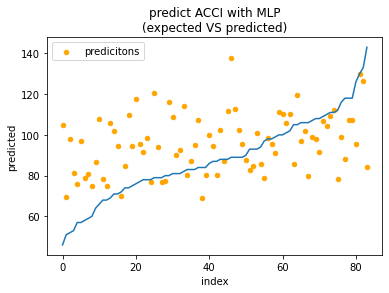

Predict AUTR with MLP :
MeanAbsoluteError:	73.67107884089152
R2 Score         :	-0.23006562584814017



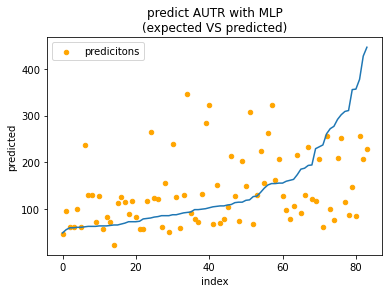

Predict INCN with MLP :
MeanAbsoluteError:	3.826487381543432
R2 Score         :	-0.1235832589350947



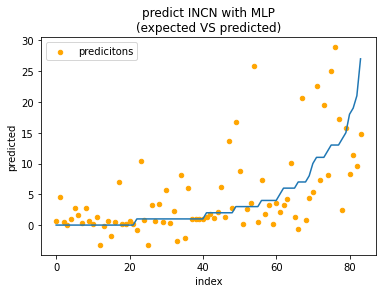

Predict INCU with MLP :
MeanAbsoluteError:	22.986619495210192
R2 Score         :	-0.8590037948136182



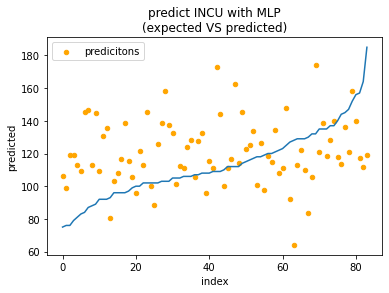

Predict SUAP with MLP :
MeanAbsoluteError:	135.17300415039062
R2 Score         :	-0.42905244071105053



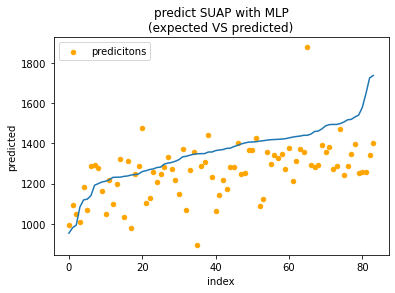

Predict ope_total with MLP :
MeanAbsoluteError:	145.62418474469865
R2 Score         :	-0.19188497476940847



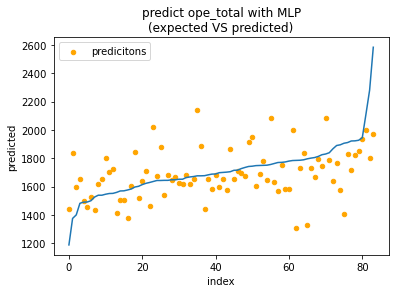

In [7]:
# display results
for target in mlp_results:
    display_mae_r2(
        model=mlp_results[target]['model'],
        train_test=mlp_results[target]['train_test'],
    )
    plot_expected_vs_predicted(
        model=mlp_results[target]['model'],
        train_test=mlp_results[target]['train_test'],
    )

----
(Test) predict ope_total using the predictions of 'ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP'
(the results aren't great)

Predict ope_total with MLP :
MeanAbsoluteError:	191.35242571149553
R2 Score         :	-1.2583889177748482



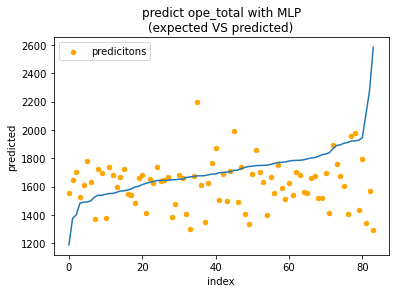

In [8]:
# target_features = ['ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP', 'ope_total']
import numpy as np

predictions = []
for target in ['ACCI', 'AUTR', 'INCN', 'INCU', 'SUAP']:
    model = mlp_results[target]['model']
    train_test = mlp_results[target]['train_test']

    val_predictions = model.predict(train_test['val_X'])
    predictions.append(val_predictions)


total = predictions[0]

for i in range (1, len(predictions)):
    total = np.add(total, predictions[i])

display_mae_r2(
    model=mlp_results['ope_total']['model'],
    train_test=mlp_results['ope_total']['train_test'],
    force_predicted=total,
)
plot_expected_vs_predicted(
    model=mlp_results['ope_total']['model'],
    train_test=mlp_results['ope_total']['train_test'],
    force_predicted=total,
)

In [9]:
# !pip install autokeras
# !pip install --upgrade keras-tuner

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable tensorflow warnings about float64/32 casting
import tensorflow as tf
from autokeras import StructuredDataRegressor
from sklearn.preprocessing import Normalizer, StandardScaler, QuantileTransformer

##### FIX for "Blas GEMM launch failed" Error
##### see https://stackoverflow.com/a/60699372/12182226
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#####


def autok():

    # All columns except yearweek and all interventions numbers
    features = df.columns[7:]
    X = df[features]
    y = df['ope_total']
    
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20)

    #standard scaler
    std_scaler = StandardScaler().fit(X) # fit doesn't affect the data
    train_X = pd.DataFrame(std_scaler.transform(train_X), columns=features)
    val_X = pd.DataFrame(std_scaler.transform(val_X), columns=features)

    # normalize
    normalizer = Normalizer().fit(X) # fit doesn't affect the data
    train_X = pd.DataFrame(normalizer.transform(train_X), columns=features)
    val_X = pd.DataFrame(normalizer.transform(val_X), columns=features)

    # reg = StructuredDataRegressor(max_trials=10, overwrite=True)
    reg = StructuredDataRegressor(max_trials=100, overwrite=True, loss="mean_absolute_error")

    # Feed the structured data regressor with training data.
    # reg.fit(train_X, train_y, epochs=200)
    reg.fit(train_X, train_y)
    # Predict with the best model.
    predicted_y = reg.predict(val_X)
    # Evaluate the best model with testing data.
    return reg, {'train_X': train_X, 'val_X': val_X, 'train_y': train_y, 'val_y': val_y}

ak_regressor, ak_train_test = autok()

Trial 69 Complete [00h 00m 03s]
val_loss: 1659.73681640625

Best val_loss So Far: 80.63164520263672
Total elapsed time: 01h 25m 36s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/417
11/11 [==============================] - 0s 3ms/step - loss: 1710.1376 - mean_squared_error: 2970163.0000
Epoch 2/417
11/11 [==============================] - 0s 3ms/step - loss: 1710.0034 - mean_squared_error: 2969705.5000
Epoch 3/417
11/11 [==============================] - 0s 3ms/step - loss: 1709.8690 - mean_squared_erro

In [10]:
ak_mae_train, _ = ak_regressor.evaluate(ak_train_test['train_X'], ak_train_test['train_y'])
print(f'MAE using autokeras : {ak_mae_train} (ON train)')

ak_mae_test, _ = ak_regressor.evaluate(ak_train_test['val_X'], ak_train_test['val_y'])
print(f'MAE using autokeras : {ak_mae_test} (ON TEST)')

11/11 [==============================] - 0s 2ms/step - loss: 104.2865 - mean_squared_error: 30391.6289
MAE using autokeras : 104.28645324707031 (ON train)
3/3 [==============================] - 0s 2ms/step - loss: 135.1080 - mean_squared_error: 34904.3945
MAE using autokeras : 135.1079864501953 (ON TEST)


In [11]:
ak_model = ak_regressor.export_model()
ak_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                160       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
re_lu (ReLU)                 (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)               

Predict ope_total with Functional :
MeanAbsoluteError:	135.10798717680433
R2 Score         :	0.08399238306151158



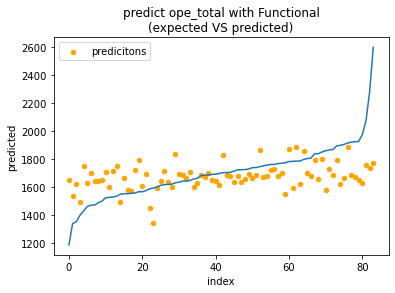

In [12]:
display_mae_r2(
    model=ak_model,
    train_test=ak_train_test,
)
plot_expected_vs_predicted(
    model=ak_model,
    train_test=ak_train_test,
)